In [1]:
import jax
from jax import numpy as jnp
from jax.numpy import linalg as jla
import jax.nn as nn
from jax.config import config; config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
from matplotlib import patches

import sys
sys.path.insert(1, '..')

from algs.train import IRL_Trainer, TracePlotter
from algs.projs import euclidean_l2ball
from env.utils import ExampleMDPs

In [18]:
mdp = ExampleMDPs.gworld1()
trainer = IRL_Trainer(mdp,policy_lr=2e-3,reward_lr=5e-1)
optimizers, trace = trainer.train(750)

Computing the expert's policy


100%|██████████| 2000/2000 [00:37<00:00, 53.28it/s]


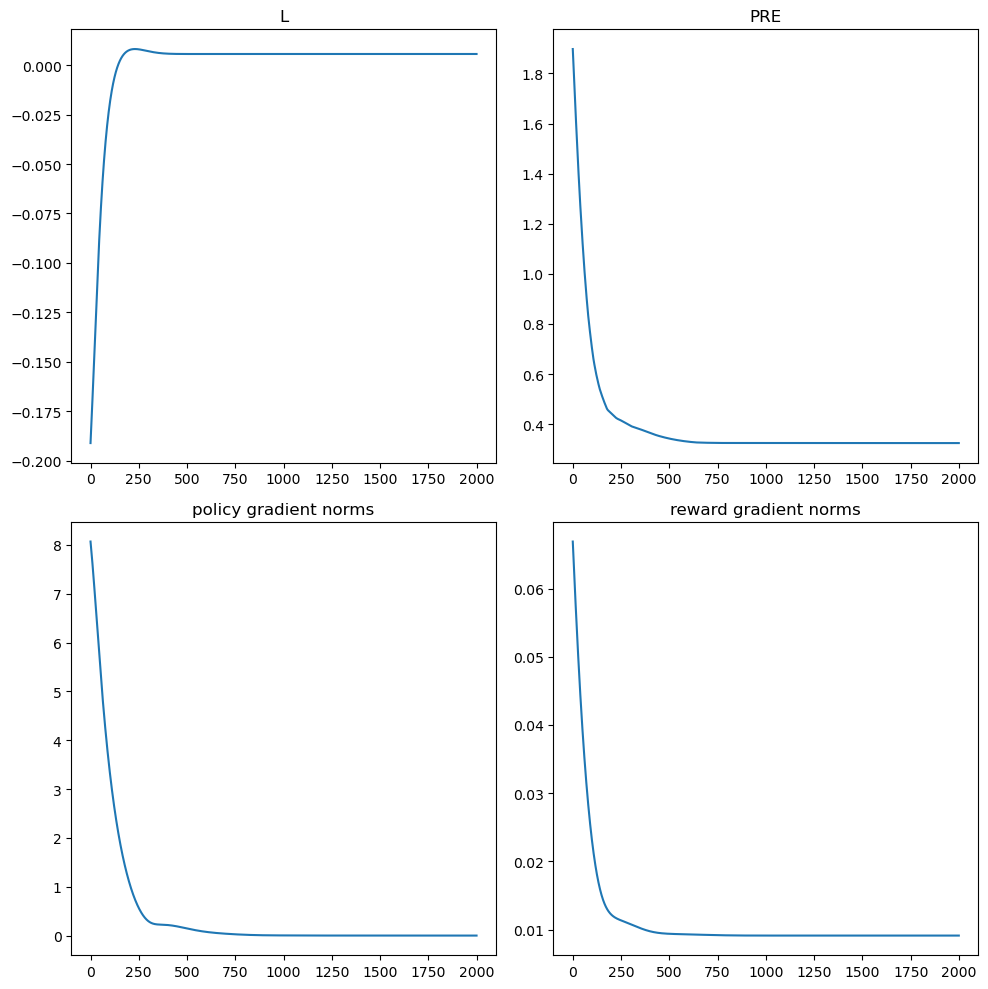

In [19]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
TracePlotter.plotScalar(ax[0,0],'L',trace)
TracePlotter.plotScalar(ax[0,1],'PRE',trace)
TracePlotter.plotGradNorms(ax[1,0],'policy',trace)
TracePlotter.plotGradNorms(ax[1,1],'reward',trace)
fig.tight_layout()
plt.show()